In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
spark_version = 'spark-3.0.3'
#spark_version = 'spark-3.<enter version>'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:14 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:15 http://ppa.launchpad.net/grap

In [2]:
# First, enter the following code to download a Postgres driver that will allow Spark to interact with Postgres:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.16.jar

--2021-08-13 00:44:10--  https://jdbc.postgresql.org/download/postgresql-42.2.16.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1002883 (979K) [application/java-archive]
Saving to: ‘postgresql-42.2.16.jar.7’

postgresql-42.2.16. 100%[===================>] 979.38K  1.21MB/s    in 0.8s    

2021-08-13 00:44:11 (1.21 MB/s) - ‘postgresql-42.2.16.jar.7’ saved [1002883/1002883]



In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Final_Regression").config("spark.driver.extraClassPath","/content/postgresql-42.2.16.jar").getOrCreate()

In [4]:
# Load in a sql functions
# Import our dependencies
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import tensorflow as tf

from pyspark.sql.functions import col, avg, sum, count, rand, randn, to_timestamp, to_date, date_format, sqrt
from pyspark.sql.functions import unix_timestamp, from_unixtime

# Import libraries
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [5]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://tq2cutebucket.s3.us-west-1.amazonaws.com/final_data.csv"
spark.sparkContext.addFile(url)
df = spark.read.option("encoding", "UTF-8").csv(SparkFiles.get("final_data.csv"), sep=",", header=True, inferSchema=True)
df.show(5)
df.count()

+-----------+--------------------+----------+--------+----------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+
| MLS_Number|      Street_Address|      City|Zip_Code|    county|County_Index|SqFtTotal|Lot_Size|Age|BathsTotal|BedsTotal|BathsFull|BathsHalf|DOM|Year_List|Year_Sold|List_Price|Sale_Price|  Listing_Date|     Sale_Date|Year_Built|
+-----------+--------------------+----------+--------+----------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+
| BE40950609|   2724 Foxglove Ct |Pleasanton|   94588|   Alameda|           8|     2051|  2949.0| 23|         3|        4|        2|        1|  6|     2021|     2021|   1450000|   1625000|5/19/2021 0:00|5/25/2021 0:00|      1998|
| ML81845215|  7873 Chestnut WAY |Pleasanton|   94588|   Alameda|           8|  

4225

In [6]:
# Drop null values
# This is a safety step in case the data is not perfect
df = df.dropDuplicates(['MLS_Number','Street_Address','City','Zip_Code','county','County_Index','SqFtTotal','Lot_Size','BedsTotal','BathsTotal','BathsFull','BathsHalf','Year_Built','List_Price','Sale_Price'])
df = df.sort("MLS_Number")
df.show(5)
df.count()

+-----------+--------------------+---------+--------+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+
| MLS_Number|      Street_Address|     City|Zip_Code|county|County_Index|SqFtTotal|Lot_Size|Age|BathsTotal|BedsTotal|BathsFull|BathsHalf|DOM|Year_List|Year_Sold|List_Price|Sale_Price|  Listing_Date|     Sale_Date|Year_Built|
+-----------+--------------------+---------+--------+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+--------------+--------------+----------+
|BA321014028|807 Dizzy Gillesp...|  Windsor|   95492|Sonoma|          20|     1520|  4400.0| 22|         2|        3|        2|        0|  0|     2021|     2021|    629000|    650000|5/23/2021 0:00|5/23/2021 0:00|      1999|
|BA321014324|  300 Via La Cumbre |Greenbrae|   94904| Marin|          15|     2419|  7479.0| 58|    

4225

In [7]:
# Process the date column (listing date and sale date)
#df.select(to_date(df.Sale_Date, 'MM/dd/yyyy HH:mm').alias('date')).show()

df = df.withColumn('Sale_Date',to_date(to_timestamp(col('Sale_Date'), 'M/d/yyyy H:mm')))
df = df.withColumn('Listing_Date',to_date(to_timestamp(col('Listing_Date'), 'M/d/yyyy H:mm')))

df.show(5)

+-----------+--------------------+---------+--------+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+------------+----------+----------+
| MLS_Number|      Street_Address|     City|Zip_Code|county|County_Index|SqFtTotal|Lot_Size|Age|BathsTotal|BedsTotal|BathsFull|BathsHalf|DOM|Year_List|Year_Sold|List_Price|Sale_Price|Listing_Date| Sale_Date|Year_Built|
+-----------+--------------------+---------+--------+------+------------+---------+--------+---+----------+---------+---------+---------+---+---------+---------+----------+----------+------------+----------+----------+
|BA321014028|807 Dizzy Gillesp...|  Windsor|   95492|Sonoma|          20|     1520|  4400.0| 22|         2|        3|        2|        0|  0|     2021|     2021|    629000|    650000|  2021-05-23|2021-05-23|      1999|
|BA321014324|  300 Via La Cumbre |Greenbrae|   94904| Marin|          15|     2419|  7479.0| 58|         3|        4|       

In [8]:
# Convert data to pandas db
reg_pd_df=df.select('county','SqFtTotal','Lot_Size','Age','BathsTotal','BedsTotal','BathsFull','BathsHalf','DOM','Year_Sold','List_Price','Sale_Price').toPandas()
#reg_pd_df=df.toPandas()
reg_pd_df.head(5)

,county,SqFtTotal,Lot_Size,Age,BathsTotal,BedsTotal,BathsFull,BathsHalf,DOM,Year_Sold,List_Price,Sale_Price
0,Sonoma,1520,4400.0,22,2,3,2,0,0,2021,629000,650000
1,Marin,2419,7479.0,58,3,4,3,0,9,2021,1299000,1460000
2,Solano,1226,8969.0,36,2,3,2,0,37,2021,449977,470000
3,Marin,2892,43560.0,138,4,4,4,0,7,2021,1599000,1781883
4,Sonoma,2339,76666.0,69,2,3,2,0,8,2021,1600000,1650000


In [9]:
# Break down county into column of county_county
application_cat = reg_pd_df.dtypes[reg_pd_df.dtypes == "object"].index.tolist()
reg_pd_df[application_cat].nunique()

county    46
dtype: int64

In [10]:
# Look at APPLICATION_TYPE value counts for binning
#  YOUR CODE GOES HERE
# Check the unique value counts to see if binning is required
county_type_counts = reg_pd_df.county.value_counts()
county_type_counts

Los Angeles        701
Riverside          412
Orange             403
San Bernardino     282
Sacramento         281
Contra Costa       237
San Diego          237
Santa Clara        208
Alameda            181
Placer             122
San Joaquin        104
Stanislaus          94
Butte               91
San Mateo           79
San Luis Obispo     75
Marin               75
Solano              60
Ventura             53
Yuba                52
El Dorado           49
Sonoma              44
San Francisco       41
Merced              39
Monterey            37
Santa Cruz          34
Yolo                31
Sutter              29
Nevada              26
Madera              18
Lake                14
Santa Barbara       13
Napa                13
Kern                12
San Benito          11
Amador              10
Mendocino           10
Shasta               9
Fresno               9
Colusa               8
Calaveras            7
Tuolumne             3
Glenn                3
Tehama               3
Tulare     

In [11]:
# Determine which values to replace if counts are less than ...?
#  YOUR CODE GOES HERE
# Determine which values to replaceapplication_type_counts
replace_county = list(county_type_counts[county_type_counts < 10].index)

# Replace in dataframe
for app in replace_county:
    reg_pd_df.county = reg_pd_df.county.replace(app,"Other")
    
# Check to make sure binning was successful
reg_pd_df.county.value_counts()

Los Angeles        701
Riverside          412
Orange             403
San Bernardino     282
Sacramento         281
San Diego          237
Contra Costa       237
Santa Clara        208
Alameda            181
Placer             122
San Joaquin        104
Stanislaus          94
Butte               91
San Mateo           79
Marin               75
San Luis Obispo     75
Solano              60
Ventura             53
Yuba                52
El Dorado           49
Other               47
Sonoma              44
San Francisco       41
Merced              39
Monterey            37
Santa Cruz          34
Yolo                31
Sutter              29
Nevada              26
Madera              18
Lake                14
Santa Barbara       13
Napa                13
Kern                12
San Benito          11
Amador              10
Mendocino           10
Name: county, dtype: int64

In [12]:
from sklearn.preprocessing import StandardScaler,OneHotEncoder
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(reg_pd_df[application_cat]))


# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,county_Alameda,county_Amador,county_Butte,county_Contra Costa,county_El Dorado,county_Kern,county_Lake,county_Los Angeles,county_Madera,county_Marin,county_Mendocino,county_Merced,county_Monterey,county_Napa,county_Nevada,county_Orange,county_Other,county_Placer,county_Riverside,county_Sacramento,county_San Benito,county_San Bernardino,county_San Diego,county_San Francisco,county_San Joaquin,county_San Luis Obispo,county_San Mateo,county_Santa Barbara,county_Santa Clara,county_Santa Cruz,county_Solano,county_Sonoma,county_Stanislaus,county_Sutter,county_Ventura,county_Yolo,county_Yuba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Merge one-hot encoded features and drop the originals
reg_pd_df = reg_pd_df.merge(encode_df,left_index=True, right_index=True)
reg_pd_df = reg_pd_df.drop(application_cat,1)
reg_pd_df.head()

,SqFtTotal,Lot_Size,Age,BathsTotal,BedsTotal,BathsFull,BathsHalf,DOM,Year_Sold,List_Price,Sale_Price,county_Alameda,county_Amador,county_Butte,county_Contra Costa,county_El Dorado,county_Kern,county_Lake,county_Los Angeles,county_Madera,county_Marin,county_Mendocino,county_Merced,county_Monterey,county_Napa,county_Nevada,county_Orange,county_Other,county_Placer,county_Riverside,county_Sacramento,county_San Benito,county_San Bernardino,county_San Diego,county_San Francisco,county_San Joaquin,county_San Luis Obispo,county_San Mateo,county_Santa Barbara,county_Santa Clara,county_Santa Cruz,county_Solano,county_Sonoma,county_Stanislaus,county_Sutter,county_Ventura,county_Yolo,county_Yuba
0,1520,4400.0,22,2,3,2,0,0,2021,629000,650000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,2419,7479.0,58,3,4,3,0,9,2021,1299000,1460000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1226,8969.0,36,2,3,2,0,37,2021,449977,470000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2892,43560.0,138,4,4,4,0,7,2021,1599000,1781883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2339,76666.0,69,2,3,2,0,8,2021,1600000,1650000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#data_df = df.select('MLS_Number','Street_Address','City','Zip_Code','county','County_Index','SqFtTotal','Lot_Size','BedsTotal','BathsTotal','BathsFull','BathsHalf','Year_Built','Sale_Price')
#data_df = df.select('county','County_Index','SqFtTotal','Lot_Size','Age','BathsTotal','BedsTotal','BathsFull','BathsHalf','DOM','Year_Sold','List_Price','Sale_Price')
reg_pd_df.dtypes

SqFtTotal                   int32
Lot_Size                  float64
Age                         int32
BathsTotal                  int32
BedsTotal                   int32
BathsFull                   int32
BathsHalf                   int32
DOM                         int32
Year_Sold                   int32
List_Price                  int32
Sale_Price                  int32
county_Alameda            float64
county_Amador             float64
county_Butte              float64
county_Contra Costa       float64
county_El Dorado          float64
county_Kern               float64
county_Lake               float64
county_Los Angeles        float64
county_Madera             float64
county_Marin              float64
county_Mendocino          float64
county_Merced             float64
county_Monterey           float64
county_Napa               float64
county_Nevada             float64
county_Orange             float64
county_Other              float64
county_Placer             float64
county_Riversi

In [15]:
# Perform descriptive analytics
# reg_pd_df.describe().transpose()
reg_pd_df.columns

Index(['SqFtTotal', 'Lot_Size', 'Age', 'BathsTotal', 'BedsTotal', 'BathsFull',
       'BathsHalf', 'DOM', 'Year_Sold', 'List_Price', 'Sale_Price',
       'county_Alameda', 'county_Amador', 'county_Butte',
       'county_Contra Costa', 'county_El Dorado', 'county_Kern', 'county_Lake',
       'county_Los Angeles', 'county_Madera', 'county_Marin',
       'county_Mendocino', 'county_Merced', 'county_Monterey', 'county_Napa',
       'county_Nevada', 'county_Orange', 'county_Other', 'county_Placer',
       'county_Riverside', 'county_Sacramento', 'county_San Benito',
       'county_San Bernardino', 'county_San Diego', 'county_San Francisco',
       'county_San Joaquin', 'county_San Luis Obispo', 'county_San Mateo',
       'county_Santa Barbara', 'county_Santa Clara', 'county_Santa Cruz',
       'county_Solano', 'county_Sonoma', 'county_Stanislaus', 'county_Sutter',
       'county_Ventura', 'county_Yolo', 'county_Yuba'],
      dtype='object')

In [16]:
#data_array = np.array(data_df.collect())
y = np.array(reg_pd_df.Sale_Price)
X = np.array(reg_pd_df.drop(columns=['Sale_Price'])) # Include the Listing Price Here

print(X)
print(y)

[[1.5200e+03 4.4000e+03 2.2000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.4190e+03 7.4790e+03 5.8000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [1.2260e+03 8.9690e+03 3.6000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 ...
 [7.8000e+02 1.3932e+04 8.3000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.1590e+03 3.7723e+04 7.1000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [8.9180e+03 1.3074e+04 1.3000e+01 ... 0.0000e+00 0.0000e+00 0.0000e+00]]
[  650000  1460000   470000 ...  1200000  2450000 13500000]


**MODEL 1:** includes **"List_Price"**

**SAMPLE SIZE** due to sample size is pretty large, > 4K, 5% of 4K is more than 200 rows. 200 is good enough for testing 

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=5)

In [18]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4013, 47) (212, 47) (4013,) (212,)


In [19]:
# Fit ML Regression to a trainingg set
# Forcing intercept to be zero
from sklearn.linear_model import LinearRegression
regression = LinearRegression(fit_intercept=False) # False = no-intercept
regression.fit(X_train, y_train)

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
# LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

In [20]:
# Predicting the test result
y_pred = regression.predict(X_test)
X[0]

array([1.520e+03, 4.400e+03, 2.200e+01, 2.000e+00, 3.000e+00, 2.000e+00,
       0.000e+00, 0.000e+00, 2.021e+03, 6.290e+05, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

In [21]:
# Print out the interceptor
# Expect intercept is zero
print("Intercept: " + str(regression.intercept_))

Intercept: 0.0


In [22]:
# Print out the coefficients
print("Coefficients: " + str(regression.coef_))

Coefficients: [ 7.05846023e+00 -3.97319975e-05  2.37809922e+02 -6.61507688e+03
  4.33821438e+03 -1.79402309e+03 -4.82105354e+03 -2.04294533e+01
  1.42877073e+04  1.01985715e+00 -2.87209600e+07 -2.88837992e+07
 -2.88898308e+07 -2.87976538e+07 -2.88553795e+07 -2.88937631e+07
 -2.89142853e+07 -2.88611547e+07 -2.88987526e+07 -2.87828276e+07
 -2.88995682e+07 -2.88884175e+07 -2.88803837e+07 -2.88669584e+07
 -2.88795840e+07 -2.88871556e+07 -2.88858686e+07 -2.88629361e+07
 -2.88757705e+07 -2.88678871e+07 -2.88765539e+07 -2.88810263e+07
 -2.88742500e+07 -2.87307020e+07 -2.88633867e+07 -2.88813855e+07
 -2.86917111e+07 -2.88857612e+07 -2.87300128e+07 -2.88174333e+07
 -2.88733102e+07 -2.88500048e+07 -2.88809702e+07 -2.88963150e+07
 -2.88669534e+07 -2.88431558e+07 -2.88797093e+07]


In [23]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#
print("Mean Squared Error(MSE): " + str(mean_squared_error(y_test, y_pred)))
print("R squared(R2): " + str(r2_score(y_test, y_pred)))

Mean Squared Error(MSE): 100260327577.81798
R squared(R2): 0.9605332854433306


In [24]:
#df = create a df of Sales_Price and Prediction values
import pandas as pd
good_result_df = pd.DataFrame({"Sale_Price": [x for x in y_test], "Good Prediction": [x for x in y_pred]})
good_result_df['Good Prediction'] = good_result_df['Good Prediction'].map('{:,.2f}'.format)
good_result_df.head(10)

,Sale_Price,Good Prediction
0,1005000,"913,281.32"
1,1175000,"1,219,022.44"
2,565000,"587,771.36"
3,950000,"959,388.14"
4,625000,"608,544.68"
5,1925000,"1,872,278.90"
6,21150000,"25,521,630.17"
7,2000000,"1,830,298.75"
8,341000,"321,158.59"
9,1450000,"1,469,391.98"


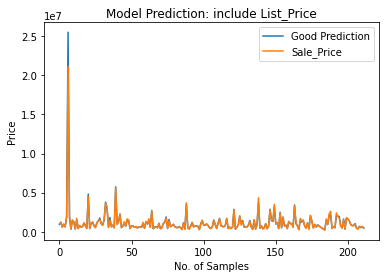

In [25]:
import matplotlib.pyplot as plt
plt.plot(y_pred)
plt.plot(y_test)
plt.title('Model Prediction: include List_Price')
plt.ylabel('Price')
plt.xlabel('No. of Samples')
plt.legend(['Good Prediction', 'Sale_Price'], loc='upper right')
plt.show()

**Model 2** does not have **List_Price**

In [26]:
#data_array = np.array(data_df.collect())
y2 = np.array(reg_pd_df.Sale_Price)
X2 = np.array(reg_pd_df.drop(columns=['Sale_Price','List_Price'])) # Exclude the List_Price Here

#your_array = your_array.astype(np.float64)
X2 = X2.astype(np.float64)
y2 = y2.astype(np.float64)

from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.05, random_state=5)

print(X2_train.shape, X2_test.shape, y2_train.shape, y2_test.shape)


(4013, 46) (212, 46) (4013,) (212,)


In [27]:
# Fit ML Regression to a training set
# Forcing intercept to be zero
from sklearn.linear_model import LinearRegression
regression2 = LinearRegression(fit_intercept=False) # False = no-intercept
regression2.fit(X2_train, y2_train)

# Predicting the test result
y_pred2 = regression2.predict(X2_test)

# Print out the interceptor
# Expect intercept is zero
print("Intercept: " + str(regression.intercept_))
# Print out the coefficients
print("Coefficients: " + str(regression.coef_))

Intercept: 0.0
Coefficients: [ 7.05846023e+00 -3.97319975e-05  2.37809922e+02 -6.61507688e+03
  4.33821438e+03 -1.79402309e+03 -4.82105354e+03 -2.04294533e+01
  1.42877073e+04  1.01985715e+00 -2.87209600e+07 -2.88837992e+07
 -2.88898308e+07 -2.87976538e+07 -2.88553795e+07 -2.88937631e+07
 -2.89142853e+07 -2.88611547e+07 -2.88987526e+07 -2.87828276e+07
 -2.88995682e+07 -2.88884175e+07 -2.88803837e+07 -2.88669584e+07
 -2.88795840e+07 -2.88871556e+07 -2.88858686e+07 -2.88629361e+07
 -2.88757705e+07 -2.88678871e+07 -2.88765539e+07 -2.88810263e+07
 -2.88742500e+07 -2.87307020e+07 -2.88633867e+07 -2.88813855e+07
 -2.86917111e+07 -2.88857612e+07 -2.87300128e+07 -2.88174333e+07
 -2.88733102e+07 -2.88500048e+07 -2.88809702e+07 -2.88963150e+07
 -2.88669534e+07 -2.88431558e+07 -2.88797093e+07]


**Pay attention to r2_score** here

In [28]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
#
print("MSE -- Mean Squared Error: " + str(mean_squared_error(y2_test, y_pred2)))
print("r2 -- R squared: " + str(r2_score(y2_test, y_pred2)))

MSE -- Mean Squared Error: 832699403517.799
r2 -- R squared: 0.6722142200798396


In [29]:
#df = create a df of Sales_Price and Prediction values
import pandas as pd
bad_result_df = pd.DataFrame({"Sale_Price": [x for x in y2_test], "Bad Prediction": [x for x in y_pred2]})
bad_result_df['Bad Prediction'] = bad_result_df['Bad Prediction'].map('{:,.2f}'.format)
bad_result_df.head(10)

,Sale_Price,Bad Prediction
0,1005000.0,"1,416,121.20"
1,1175000.0,"1,559,513.55"
2,565000.0,"639,187.61"
3,950000.0,"1,152,340.72"
4,625000.0,"526,425.80"
5,1925000.0,"965,161.08"
6,21150000.0,"10,581,912.84"
7,2000000.0,"1,322,725.73"
8,341000.0,"564,749.91"
9,1450000.0,"2,446,670.51"


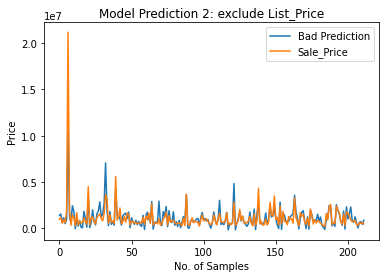

In [30]:
import matplotlib.pyplot as plt
plt.plot(y_pred2)
plt.plot(y2_test)
plt.title('Model Prediction 2: exclude List_Price')
plt.ylabel('Price')
plt.xlabel('No. of Samples')
plt.legend(['Bad Prediction', 'Sale_Price'], loc='upper right')
plt.show()

**The role** of List_price???

**END**